In [44]:
import pandas as pd
import numpy as np
import networkx as nx 
import dynetx as dn
import matplotlib.pyplot as plt
import random
from alive_progress import alive_bar
import time
from collections import defaultdict
import seaborn as sns
from igraph import Graph

In [2]:
def n_m_anonymity(G):
    
    # Create ego network
    ego_properties = {}
    
    # Obtain (n, m) value for each node
    for node in range(G.vcount()):
        ego_net = G.subgraph(G.neighborhood(node))
        
        n = ego_net.vcount()
        m = ego_net.ecount()
        
        ego_properties[node] = (n, m)
    
    # Store nodes as keys and the frequency of its (n,m) in the network as values
    frequency_dict = {}
    for node, (n, m) in ego_properties.items():
        freq_count = sum(1 for props in ego_properties.values() if props == (n, m))
        frequency_dict[node] = freq_count
    
    # Calculate the percentage of nodes with unique (n, m) values (frequency of 1)
    unique_count = sum(1 for count in frequency_dict.values() if count == 1)
    total_nodes = G.vcount()
    percentage_unique = (unique_count / total_nodes) * 100  
    
    return frequency_dict

In [3]:
def betweenness_centra_ig(G):
    betweenness_centrality = G.betweenness(directed=True)

    betweenness_ranking = {node: centrality for node, centrality in sorted(zip(range(len(betweenness_centrality)), betweenness_centrality), key=lambda x: x[1], reverse=True)}
    
    return betweenness_ranking

In [66]:
def snapshots_uniqueness_betweenness(edges, step=0.02, part=1):
    unique_top10 = []
    unique_mid10 = []
    unique_last10 = []
    unique_start10 = []
    unique_percentage = []
    count = []
    precision = []
    recall = []
    nodes_num = []
    den = []
    
    G = nx.DiGraph()
    G.add_edges_from(edges)
    M = G.number_of_edges()

    # Starting from 5% of the network
    for i in range(int(0.05*M), int(part*M), int(step*M)):
        # Create Snapshot
        sub_edge = edges[:i]
        snapshot = Graph.TupleList(sub_edge, directed=True)
        N = snapshot.vcount()
            
        # Calculate (n, m) anonymity
        anonymity_dict = n_m_anonymity(snapshot)
        unique_count = sum(1 for count in anonymity_dict.values() if count == 1)
        percentage_unique = (unique_count / N) * 100
        
        # Calculate betweenness Ranking
        #rank = betweenness_centra(snapshot)
        rank = betweenness_centra_ig(snapshot)
        
        dens = snapshot.density(loops=False)
        den.append(dens)

        # top_10 = list(rank.keys())[:int(0.1 * len(rank))]
        # last_10 = list(rank.keys())[int(0.9 * len(rank)):]
        # start_10 = list(rank.keys())[int(0.1 * len(rank)) : int(0.2 * len(rank))]
        # mid_10 = list(rank.keys())[int(0.4 * len(rank)) : int(0.5 * len(rank))]
        top_10 = list(rank.keys())[:int(0.1 * N)]
        last_10 = list(rank.keys())[int(0.9 * N):]
        start_10 = list(rank.keys())[int(0.1 * N) : int(0.2 * N)]
        mid_10 = list(rank.keys())[int(0.4 * N) : int(0.5 * N)]
        
        # Precision: In the retrieved top 10% nodes, how many are indeed unique
        
        top_10_percent_nodes_values = {node: anonymity_dict[node] for node in top_10}
        mid_10_percent_nodes_values = {node: anonymity_dict[node] for node in mid_10}
        last_10_percent_nodes_values = {node: anonymity_dict[node] for node in last_10}
        start_10_percent_nodes_values = {node: anonymity_dict[node] for node in start_10}
        
        # Top 10%
        unique_count_top = sum(1 for count in top_10_percent_nodes_values.values() if count == 1)
        unique_top10.append(unique_count_top)
        # mid 10%
        unique_count_mid = sum(1 for count in mid_10_percent_nodes_values.values() if count == 1)
        unique_mid10.append(unique_count_mid)     
        # Last 10%
        unique_count_last = sum(1 for count in last_10_percent_nodes_values.values() if count == 1)
        unique_last10.append(unique_count_last)
        # 10%-20%
        unique_count_start = sum(1 for count in start_10_percent_nodes_values.values() if count == 1)
        unique_start10.append(unique_count_start)
        
        
        # Precision: In the retrieved top 10% nodes, how many are indeed unique
        if(len(top_10) > 0):
            precision.append(unique_count_top/len(top_10))
        else:
            precision.append(0)
        # Recall: Out of all unique nodes, how many are retrieved in top 10%
        if(unique_count > 0):
            recall.append(unique_count_top/unique_count)
        else:
            recall.append(0)
        nodes_num.append(N)
        count.append(unique_count)
        unique_percentage.append(percentage_unique)
             
    return count, unique_percentage, nodes_num, unique_top10, unique_mid10, unique_last10, unique_start10, precision, recall, den

In [ ]:
# Func 3: Network Properties w/ uniqueness
def snapshots_properties(edges, step=0.02):
    avg_degree = []
    density = []
    avg_dist = []
    top_closeness = []
    
    G = nx.DiGraph()
    G.add_edges_from(edges)
    M = G.number_of_edges()

    for i in range(10, M, int(step*M)):
        # Create Snapshot
        sub_edge = edges[:i]
        snapshot = Graph.TupleList(sub_edge, directed=True)
        N = snapshot.vcount()
        
        

        # Avg Degree
        degrees = dict(snapshot.degree())
        avg_degree.append(sum(degrees.values()) / len(degrees))
        
        # # Avg Distance
        # largest_weakly_connected_component = max(nx.weakly_connected_components(snapshot), key=len)
        # if len(largest_weakly_connected_component) > 1:
        #     avg_dist.append(nx.average_shortest_path_length(snapshot.subgraph(largest_weakly_connected_component)))
        # else:
        #     avg_dist.append(0)  # If the largest weakly connected component has only one node, average distance is 0
        
              
    return avg_degree, density

In [120]:
def snapshots_uniqueness_betweenness_stack(edges, step=0.02, part=1):
    unique_percentage = []
    count = []
    nodes_num = []
    stack =[]
    
    G = nx.DiGraph()
    G.add_edges_from(edges)
    M = G.number_of_edges()

    # Starting from 5% of the network
    for i in range(int(0.05*M), int(part*M), int(step*M)):
        # Create Snapshot
        sub_edge = edges[:i]
        snapshot = Graph.TupleList(sub_edge, directed=True)
        N = snapshot.vcount()
            
        # Calculate (n, m) anonymity
        # anonymity_dict = n_m_anonymity(snapshot)
        # unique_count = sum(1 for count in anonymity_dict.values() if count == 1)
        # percentage_unique = (unique_count / N) * 100
        
        total_degree = sum(snapshot.degree())
        avg_degree = total_degree / N
        
        stack.append(avg_degree)
        
        # # Calculate betweenness Ranking
        # #rank = betweenness_centra(snapshot)
        # rank = betweenness_centra_ig(snapshot)
        
        # # TODO: When i reaches 20%, 50%, 80% of M calculate the uniquness distribution over the betweenness ranking   
        # for i in range(10):
        #     if i == 0:
        #         get_10 = list(rank.keys())[: int(0.1 * N)]
        #     elif i == 9:
        #         get_10 = list(rank.keys())[int(0.9 * N):]
        #     else:
        #         get_10 = list(rank.keys())[int(0.1 * i * N) : int(0.1 * (i+1) * N)]
        #     percent_nodes_values = {node: anonymity_dict[node] for node in get_10}
        #     unique_count = sum(1 for count in percent_nodes_values.values() if count == 1)
        #     stack.append(unique_count)
        
        nodes_num.append(N)
        # count.append(unique_count)
        # unique_percentage.append(percentage_unique)
             
    return stack

In [6]:
# Func 4: Plotting 
def plot_uniquecount(count):
    plt.plot(count, linestyle='-', color='b')
    #plt.plot(unique_percentage, linestyle='-', color='r')
    plt.xlabel('Snapshot')
    plt.ylabel('Unique Node Number')
    plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
    plt.title('Unique Node Percentage for Each Snapshot')
    #plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()
    
    
def plot_uniquepercent(count, percent):
    fig, ax1 = plt.subplots()
    #ax1.set_lable('Network Develop with timestamps')
    ax1.set_ylabel('Percentage of unique nodes/%')
    ax1.plot(percent, linestyle='-', color='b', label='uniqueness percentage')

    plt.legend()

    ax2 = ax1.twinx()
    ax2.set_ylabel('No. of Unique nodes')
    ax2.plot(count, linestyle='-', color='r', label='No. of unique nodes')

    fig.tight_layout()
    plt.title('Unique Node Percentage for Each Snapshot with (n, m) size of 1')
    plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
    # plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()  


def plot_uniquecentrality(count, top, mid, last, start):
    plt.plot(count, linestyle='-', color='b', label='Full Snapshot')
    plt.plot(top, linestyle='-', color='r', label='Top 10% Betweenness')
    plt.plot(start, linestyle='-', color='purple', label='Top 10%-20% Betweenness')
    plt.plot(mid, linestyle='-', color='g', label='Middle Betweenness (40-50%)')
    plt.plot(last, linestyle='-', color='y', label='Last 10% Betweenness')
    
    plt.xlabel('Network Develop with timestamps')
    plt.ylabel('No. of unique nodes')
    plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
    plt.title('Number of unique nodes for Each Snapshot with (n, m) size of 1')
    # plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()  
    

def plot_uniqueproperty(count, percent, avg_degree, top_closeness):
    fig, ax1 = plt.subplots()
    #ax1.set_xlable('Snapshot at Timestamp')
    ax1.set_ylabel('Percentage of unique nodes')
    ax1.plot(percent, linestyle='-', color='b', label='Full Snapshot')
    ax1.plot(top_closeness, linestyle='-', color='y', label='Top 10% Closeness')
    # ax1.tick_params(axis='y')
    plt.legend()

    ax2 = ax1.twinx()
    ax2.set_ylabel('Average Degree/Distance')

    ax2.plot(avg_degree, linestyle='-', color='r', label='Average Degree')
    #ax2.plot(avg_dist, linestyle='-', color='g', label='Average Distance')
    # plt.plot(density, linestyle='-', color='purple', label='Density')
    # ax2.tick_params(axis='y')

    fig.tight_layout()
    plt.title('Unique Node Percentage for Each Snapshot with (n, m) size of 1')
    plt.xlabel('Network Develop with timestamps')
    plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
    # plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()  
    

In [90]:
def plot_data(count, nodes_num, precision, recall):
    fig, ax1 = plt.subplots()
    #ax1.set_xlable('Snapshot at Timestamp')
    ax1.set_ylabel('Uniqueness')
    ax1.plot(count, linestyle='-', color='b', label='Full Snapshot Unique nodes')
    ax1.plot(nodes_num, linestyle='-', color='y', label='No. of nodes')
    # ax1.tick_params(axis='y')
    plt.legend()

    ax2 = ax1.twinx()
    ax2.set_ylabel('Betweenness Top 10%')

    ax2.plot(precision, linestyle='-', color='r', label='Precision')
    ax2.plot(recall, linestyle='-', color='g', label='Recall')
    # plt.plot(density, linestyle='-', color='purple', label='Density')
    # ax2.tick_params(axis='y')

    fig.tight_layout()
    plt.title('Unique Node Percentage for Each Snapshot with (n, m) size of 1')
    plt.xlabel('Network Develop with timestamps')
    
    #percentages = [i * 10 for i in range(len(count))]
    #plt.xticks(range(len(count)), percentages)
    #plt.xticks(range(0, len(count)+1, 10), [f'{i}% ' for i in range(0, 101, int(10*100/len(count)))])
    # plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()  

### Dataset 1

In [9]:
edge_list_file = 'data/ia-reality-call.edges'
edges = []

with open(edge_list_file, 'r') as file:
    for line in file:
        source, target, _ = map(int, line.strip().split(',')[:3])
        edge = (source, target)
        if edge not in edges:
            edges.append(edge)   # dropping repeating edges, each edge only appear once

G = nx.DiGraph()
G.add_edges_from(edges)
print(G.number_of_nodes())
print(G.number_of_edges())

6809
9484


In [96]:
count, unique_percentage, nodes_num, top, mid, last, start, precision, recall, den = snapshots_uniqueness_betweenness(edges)

In [67]:
count, unique_percentage, nodes_num, top, mid, last, start, precision, recall, den = snapshots_uniqueness_betweenness(edges, step=0.01, part=0.2)

In [114]:
stack1 = snapshots_uniqueness_betweenness_stack(edges)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.747932672609678


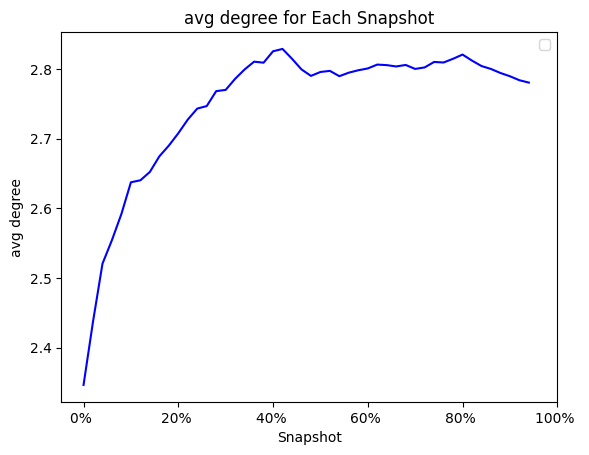

In [116]:
stack1 = snapshots_uniqueness_betweenness_stack(edges)
print(np.mean(stack1))
plt.plot(stack1, linestyle='-', color='b')
#plt.plot(unique_percentage, linestyle='-', color='r')
plt.xlabel('Snapshot')
plt.ylabel('avg degree')
plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
plt.title('avg degree for Each Snapshot')
#plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
plt.legend()
plt.show()

In [71]:
print(np.mean(unique_percentage), np.mean(precision), np.mean(recall), np.mean(den))

2.862712154407472 0.26615282105559185 0.9248079878639253 0.000617346797844974


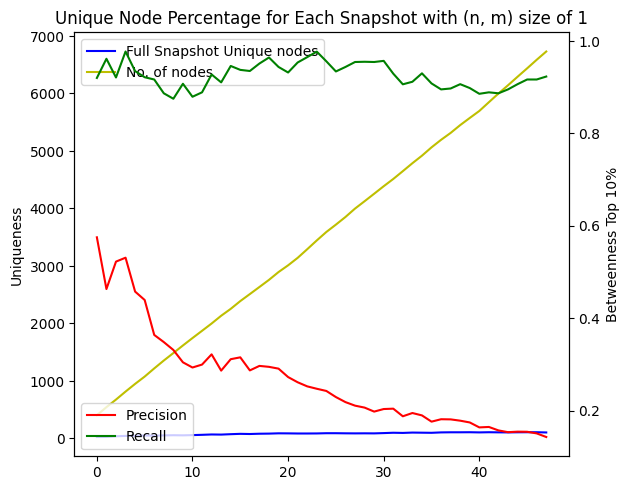

In [97]:
plot_data(count, nodes_num, precision, recall)

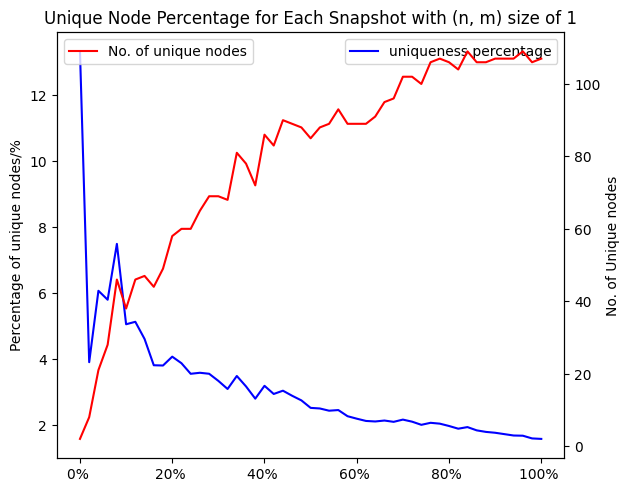

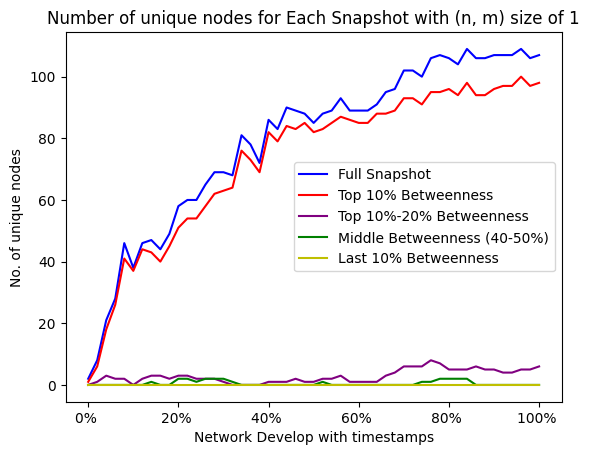

In [15]:
plot_uniquepercent(count, unique_percentage)
plot_uniquecentrality(count, top, mid, last, start)

### DA2

In [19]:
with open('data/mooc_actions.tsv', 'r') as file:
    # ignoring the first row since they are labels
    lines = file.readlines()[1:]

unique_edges = set()
edge_list2 = []
for line in lines:
    parts = line.split()
    source = int(parts[1])
    target = int(parts[2])
    # Ignore self-edges and repeating edges
    if source != target and (source, target) not in unique_edges:
        edge_list2.append((source, target))
        unique_edges.add((source, target))

G = nx.DiGraph()
G.add_edges_from(edge_list2)
print(G.number_of_nodes())
print(G.number_of_edges())

# edge_list_file = 'data/mooc_actions.tsv'
# edges2 = []

# with open(edge_list_file, 'r') as file:
#     for line in file:
#         source, target = map(int, line.strip().split(',')[1:3])
#         edge = (source, target)
#         if edge not in edges2:
#             edges2.append(edge)   # dropping repeating edges, each edge only appear once

7047
178406


In [98]:
count2, unique_percentage2, nodes_num2, top2, mid2, last2, start2, precision2, recall2, den2 = snapshots_uniqueness_betweenness(edge_list2)

In [75]:
count2, unique_percentage2, nodes_num2, top2, mid2, last2, start2, precision2, recall2, den2 = snapshots_uniqueness_betweenness(edge_list2, step=0.01, part=0.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


31.72914377113452


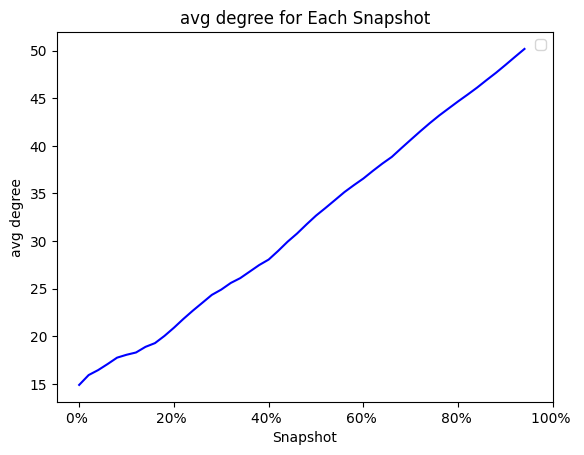

In [117]:
stack1 = snapshots_uniqueness_betweenness_stack(edge_list2)
print(np.mean(stack1))
plt.plot(stack1, linestyle='-', color='b')
#plt.plot(unique_percentage, linestyle='-', color='r')
plt.xlabel('Snapshot')
plt.ylabel('avg degree')
plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
plt.title('avg degree for Each Snapshot')
#plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
plt.legend()
plt.show()

In [76]:
print(np.mean(unique_percentage2), np.mean(precision2), np.mean(recall2), np.mean(den2))

2.672387247678409 0.10261882298137004 0.40720803143488293 0.0037785238971999157


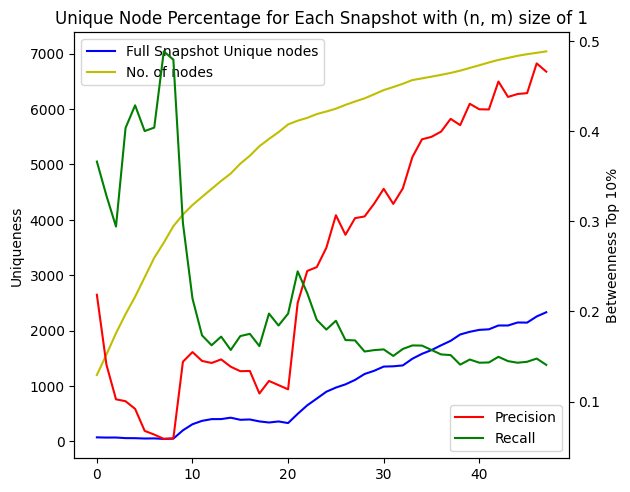

In [99]:
plot_data(count2, nodes_num2, precision2, recall2)

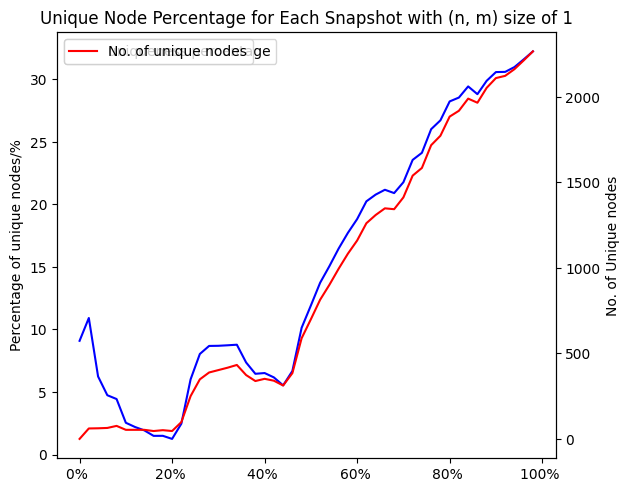

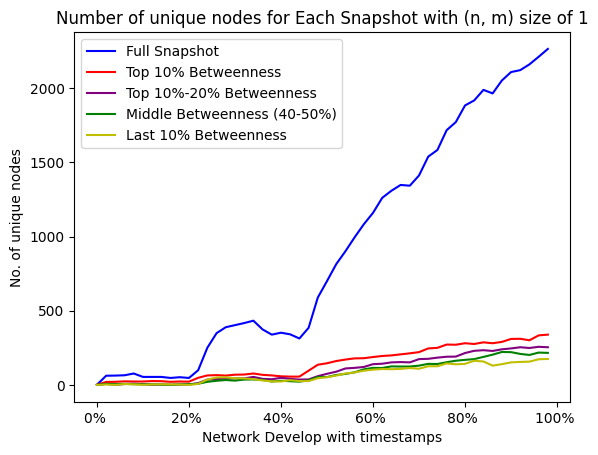

In [ ]:
plot_uniquepercent(count2, unique_percentage2)
plot_uniquecentrality(count2, top2, mid2, last2, start2)

### DA 3

In [25]:
edge_list_file = 'data/ia-contacts_hypertext2009.edges'
edges3 = []

with open(edge_list_file, 'r') as file:
    for line in file:
        source, target, _ = map(int, line.strip().split(',')[:3])
        edge = (source, target)
        if edge not in edges3:
            edges3.append(edge)   # dropping repeating edges, each edge only appear once

G = nx.DiGraph()
G.add_edges_from(edges3)
print(G.number_of_nodes())
print(G.number_of_edges())

113
2498


In [102]:
count3, unique_percentage3, nodes_num3, top3, mid3, last3, start3, precision3, recall3, den3 = snapshots_uniqueness_betweenness(edges3)

In [79]:
count3, unique_percentage3, nodes_num3, top3, mid3, last3, start3, precision3, recall3, den3 = snapshots_uniqueness_betweenness(edges3, step=0.01, part=0.2)

24.852461544406275


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


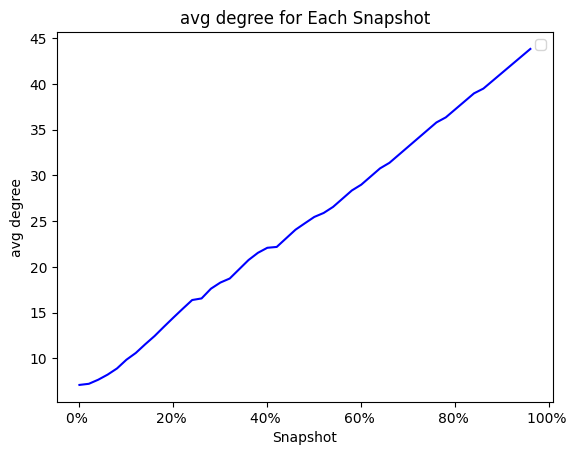

In [118]:
stack1 = snapshots_uniqueness_betweenness_stack(edges3)
print(np.mean(stack1))
plt.plot(stack1, linestyle='-', color='b')
#plt.plot(unique_percentage, linestyle='-', color='r')
plt.xlabel('Snapshot')
plt.ylabel('avg degree')
plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
plt.title('avg degree for Each Snapshot')
#plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
plt.legend()
plt.show()

In [80]:
print(np.mean(unique_percentage3), np.mean(precision3), np.mean(recall3), np.mean(den3))

54.479642015057856 0.9765625 0.16907024487842554 0.0702948780519263


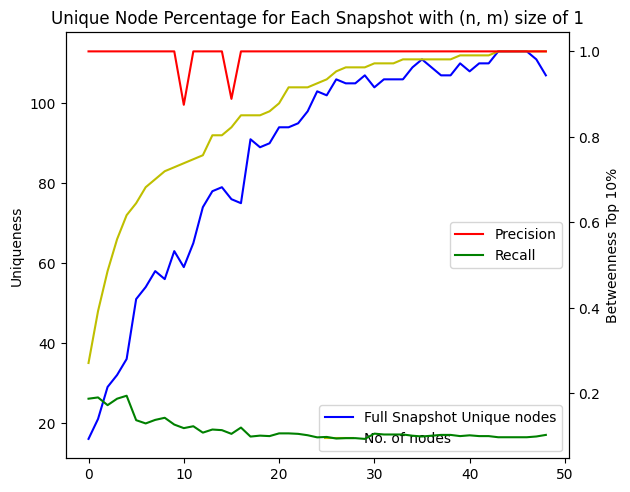

In [103]:
plot_data(count3, nodes_num3, precision3, recall3)

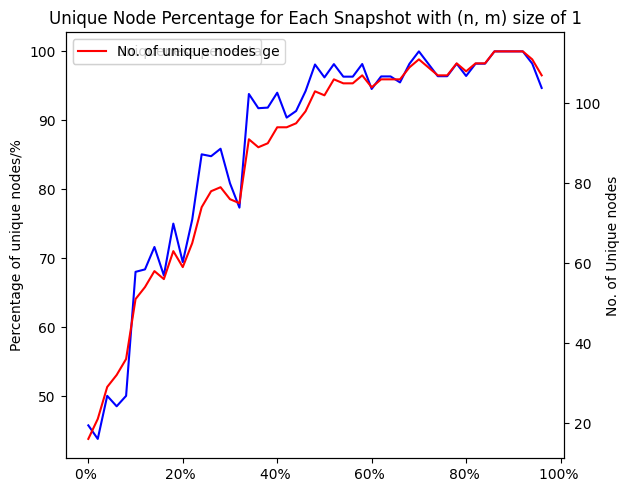

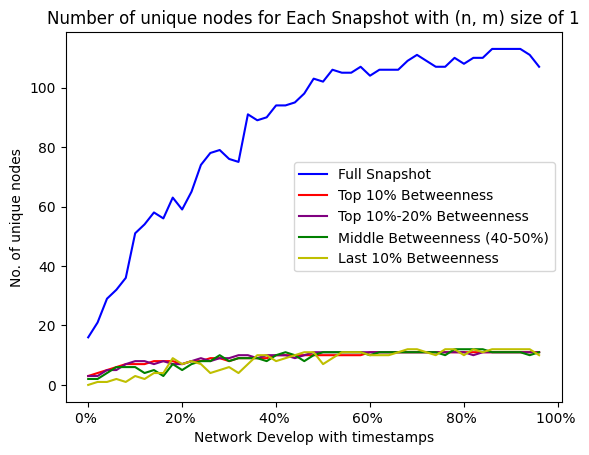

In [104]:
plot_uniquepercent(count3, unique_percentage3)
plot_uniquecentrality(count3, top3, mid3, last3, start3)

### DATA4

In [27]:
with open('data/facebook_wall.csv', 'r') as file:
    # ignoring the first row since they are labels
    lines = file.readlines()[1:]

unique_edges = set()
edge_list4 = []
for line in lines:
    parts = line.split(',')
    source = int(parts[0])
    target = int(parts[1])
    # Ignore self-edges and repeating edges
    if source != target and (source, target) not in unique_edges:
        edge_list4.append((source, target))
        unique_edges.add((source, target))

G = nx.DiGraph()
G.add_edges_from(edge_list4)
print(G.number_of_nodes())
print(G.number_of_edges())

45813
264004


In [88]:
count4, unique_percentage4, nodes_num4, top4, mid4, last4, start4, precision4, recall4, den4 = snapshots_uniqueness_betweenness(edge_list4)

In [105]:
count4, unique_percentage4, nodes_num4, top4, mid4, last4, start4, precision4, recall4, den4 = snapshots_uniqueness_betweenness(edge_list4, step=0.01, part=0.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9.873124208834051


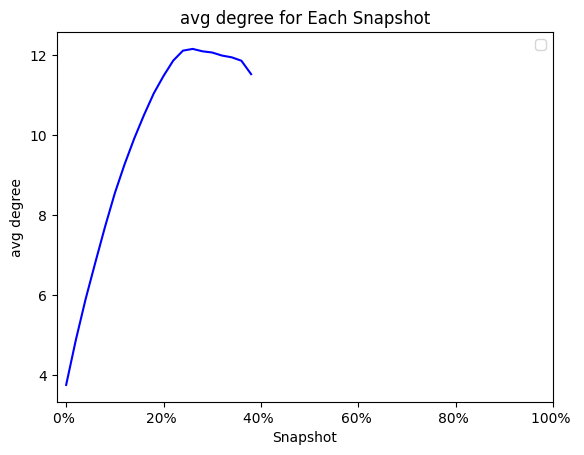

In [121]:
stack1 = snapshots_uniqueness_betweenness_stack(edge_list4, step=0.05)
print(np.mean(stack1))
plt.plot(stack1, linestyle='-', color='b')
#plt.plot(unique_percentage, linestyle='-', color='r')
plt.xlabel('Snapshot')
plt.ylabel('avg degree')
plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
plt.title('avg degree for Each Snapshot')
#plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
plt.legend()
plt.show()

In [89]:
print(np.mean(unique_percentage4), np.mean(precision4), np.mean(recall4), np.mean(den4))

5.503252107295263 0.3677634768387657 0.6750517320256738 0.0002065086289490973


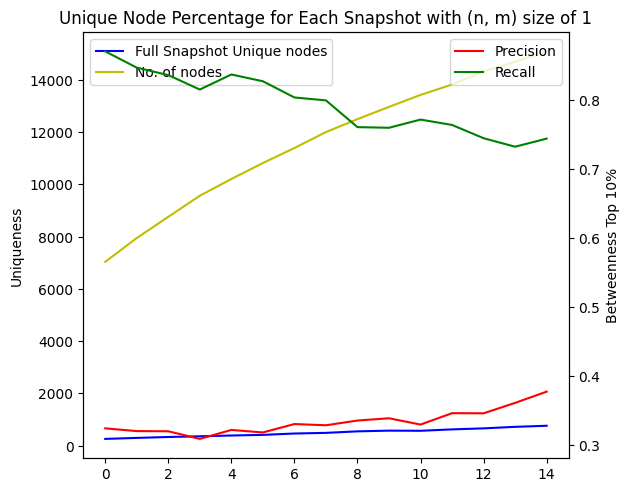

In [106]:
plot_data(count4, nodes_num4, precision4, recall4)

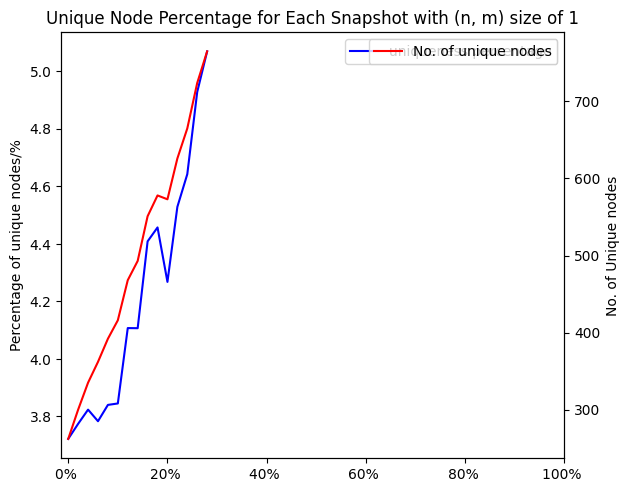

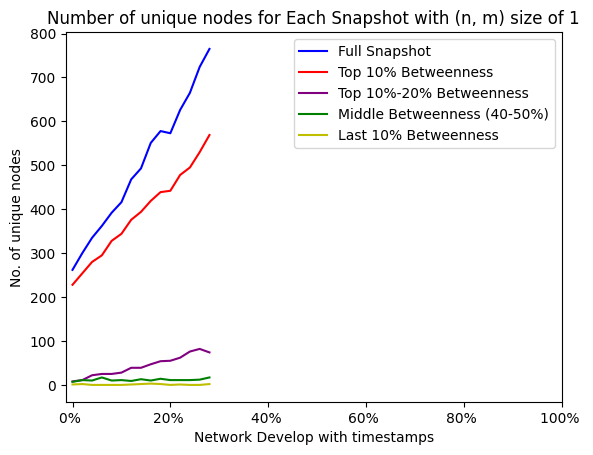

In [107]:
plot_uniquepercent(count4, unique_percentage4)
plot_uniquecentrality(count4, top4, mid4, last4, start4)

### DATA5

In [28]:
with open('data/sp_infections.csv', 'r') as file:
    # ignoring the first row since they are labels
    lines = file.readlines()[1:]

unique_edges = set()
edge_list5 = []
for line in lines:
    parts = line.split(',')
    source = int(parts[0])
    target = int(parts[1])
    # Ignore self-edges and repeating edges
    if source != target and (source, target) not in unique_edges:
        edge_list5.append((source, target))
        unique_edges.add((source, target))

G = nx.DiGraph()
G.add_edges_from(edge_list5)
print(G.number_of_nodes())
print(G.number_of_edges())

10972
52761


In [93]:
count5, unique_percentage5, nodes_num5, top5, mid5, last5, start5, precision5, recall5, den5 = snapshots_uniqueness_betweenness(edge_list5)

In [83]:
count5, unique_percentage5, nodes_num5, top5, mid5, last5, start5, precision5, recall5, den5 = snapshots_uniqueness_betweenness(edge_list5, step=0.01, part=0.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9.480721754953572


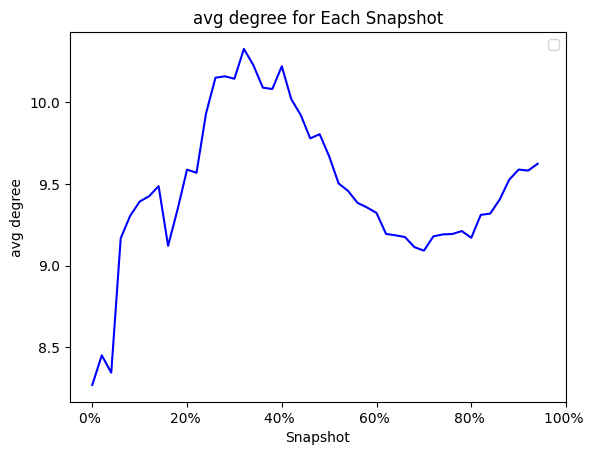

In [119]:
stack1 = snapshots_uniqueness_betweenness_stack(edge_list5)
print(np.mean(stack1))
plt.plot(stack1, linestyle='-', color='b')
#plt.plot(unique_percentage, linestyle='-', color='r')
plt.xlabel('Snapshot')
plt.ylabel('avg degree')
plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
plt.title('avg degree for Each Snapshot')
#plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
plt.legend()
plt.show()

In [84]:
print(np.mean(unique_percentage5), np.mean(precision5), np.mean(recall5), np.mean(den5))

18.421635028227442 0.35918923332125713 0.19581777788602883 0.0035151901937762998


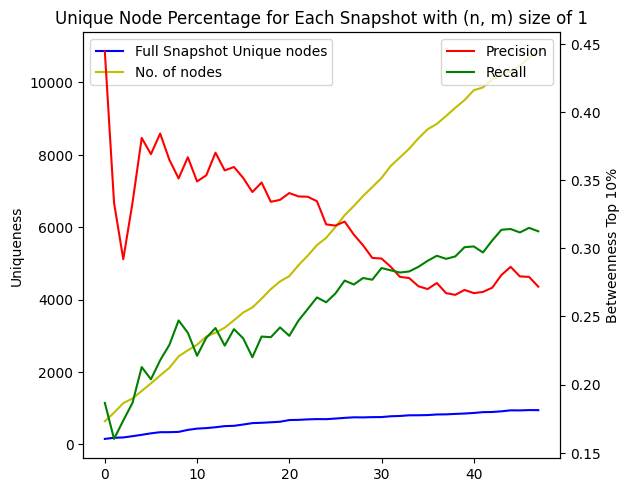

In [94]:
plot_data(count5, nodes_num5, precision5, recall5)

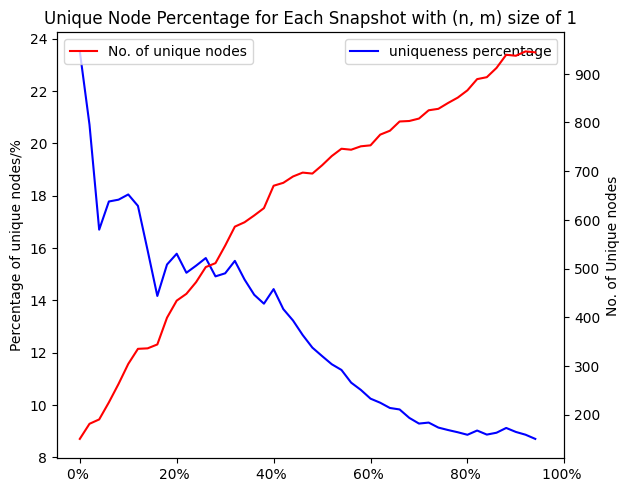

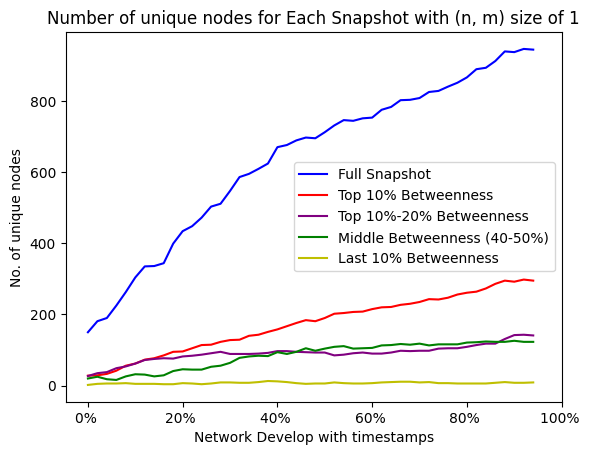

In [95]:
plot_uniquepercent(count5, unique_percentage5)
plot_uniquecentrality(count5, top5, mid5, last5, start5)

### DATA 6

In [122]:
with open('data/internet_as.csv', 'r') as file:
    # ignoring the first row since they are labels
    lines = file.readlines()[1:]

unique_edges = set()
edge_list6 = []
for line in lines:
    parts = line.split(',')
    source = int(parts[0])
    target = int(parts[1])
    # Ignore self-edges and repeating edges
    if source != target and (source, target) not in unique_edges:
        edge_list6.append((source, target))
        unique_edges.add((source, target))

G = nx.DiGraph()
G.add_edges_from(edge_list6)
print(G.number_of_nodes())
print(G.number_of_edges())

34761
114496


In [124]:
count6, unique_percentage6, nodes_num6, top6, mid6, last6, start6, precision6, recall6, den6 = snapshots_uniqueness_betweenness(edge_list6)

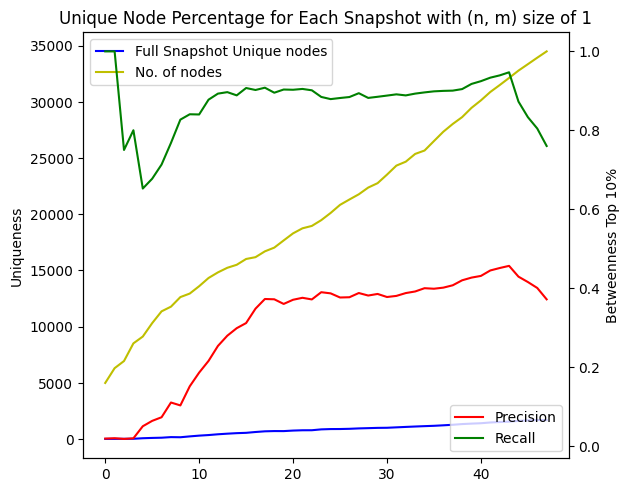

In [125]:
plot_data(count6, nodes_num6, precision6, recall6)

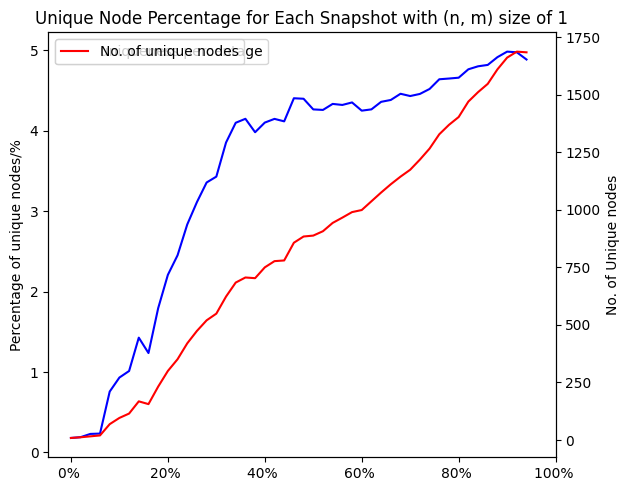

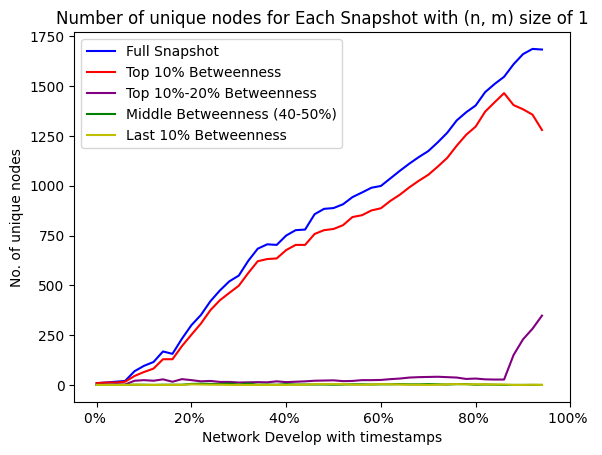

In [126]:
plot_uniquepercent(count6, unique_percentage6)
plot_uniquecentrality(count6, top6, mid6, last6, start6)